# Проект_e-commerce

#### В.С. Бирин, А. О. Шабалин

In [1626]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway, ttest_ind, chi2_contingency

Загружаем датасет

In [1627]:
df = pd.read_csv('data.csv', delimiter=',')

Переименовываем столбцы в формате PEP8

In [1628]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.rename(columns={"sessiondurationsec": "session_duration_sec"})

Переводим столбцы в тип datetime

In [1629]:
col_names = ["session_start", "session_end",
             "session_date", "order_dt"]
df[col_names] = df[col_names].apply(pd.to_datetime)

Удаляем строки с пропущенными обязательными данными

In [1630]:
col_names = ["user_id", "region",
             "device", "channel",
             "session_start", "session_end",
             "session_date", "month",
             "day", "hour_of_day"]  # обязательные столбцы
df = df.drop(df[df[col_names].isnull().any(axis=1)].index.tolist())
len(df)

999

Удаляем дубликаты

In [1631]:
df = df.drop(df[df.duplicated(["user_id", "session_start"])].index.tolist())
len(df)

997

In [1632]:
len(df["user_id"].unique()), df["user_id"].count()  # все пользователи уникальные

(997, 997)

In [1633]:
df["session_start"].apply(lambda x: 2019 <= x.to_pydatetime().year < 2020).all()  # все session_start в 2019 году

True

In [1634]:
df["session_end"].apply(lambda x: x.year == 2019 <= x.to_pydatetime().year < 2020).all()  # все session_end в 2019 году

True

In [1635]:
df.apply(lambda x: x["session_start"].date() == x["session_date"].date(),
         axis=1).all()  # все session_start совпадают с session_date

True

In [1636]:
df.apply(lambda x:
         (x["session_end"] - x["session_start"] - pd.Timedelta(
             seconds=x["session_duration_sec"])).nanoseconds < 1000,
         axis=1).all()  # все session_start + duration < session_end


True

Форматируем столбец *promo_code*

In [1637]:
df[["user_id", "promo_code"]]

,user_id,promo_code
0,529697267522,0.0
1,601292388085,NaN
2,852898876338,NaN
3,998513020664,NaN
4,240702200943,NaN
...,...,...
1007,246163171672,NaN
1008,660140862425,NaN
1009,898253063062,NaN
1010,780224321316,NaN


In [1638]:
df["promo_code"] = df.apply(lambda x: 0 if x["promo_code"] is None or x["promo_code"] == 0 else 1, axis=1)
df[["user_id", "promo_code"]]

,user_id,promo_code
0,529697267522,0
1,601292388085,1
2,852898876338,1
3,998513020664,1
4,240702200943,1
...,...,...
1007,246163171672,1
1008,660140862425,1
1009,898253063062,1
1010,780224321316,1


Создаём столбец *total_price* на основе *revenue* и *promo_code*

In [1639]:
df["total_price"] = df.apply(lambda x: x["revenue"] * 0.9 if x["promo_code"] == 1 else x["revenue"], axis=1).fillna(0)
df[["user_id", "total_price"]]

,user_id,total_price
0,529697267522,9999.0
1,601292388085,0.0
2,852898876338,0.0
3,998513020664,0.0
4,240702200943,0.0
...,...,...
1007,246163171672,0.0
1008,660140862425,0.0
1009,898253063062,0.0
1010,780224321316,0.0


Смотрим на *total_price*

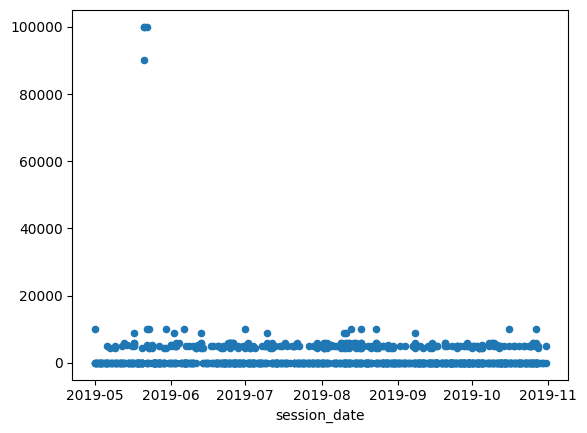

In [1640]:
sc = df[["session_date", "total_price"]]
sc.plot.scatter(x="session_date", y="total_price")
plt.ylabel("")
plt.show()

Избавляемся от выбросов по *total_price* 
1, 90'000 и 100'000 не могут существовать одновременно.

In [1641]:
df = df[((df["total_price"] > 1) | (df["total_price"] == 0)) & (df["total_price"] < 90000)]
df[["user_id", "total_price"]]

,user_id,total_price
0,529697267522,9999.0
1,601292388085,0.0
2,852898876338,0.0
3,998513020664,0.0
4,240702200943,0.0
...,...,...
1007,246163171672,0.0
1008,660140862425,0.0
1009,898253063062,0.0
1010,780224321316,0.0


Заменяем опечатки в данных столбца *region*

In [1642]:
df["region"] = (df["region"]
                .replace("United States", "United States")
                .replace("Frаnce", "France")
                .replace("Unjted States", "United States")
                .replace("Germany", "Germany")
                .replace("UK", "UK")
                .replace("France", "France")
                .replace("Frаncе", "France")
                .replace("Franсe", "France")
                .replace("germany", "Germany")
                .replace("UК", "UK"))

Заменяем опечатки в столбце *device*

In [1643]:
df["device"] = df["device"].replace("android", "Android")

Заменяем опечатки в столбце *channel*

In [1644]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")

Создаём новый столбец *visit_time* - время суток

In [1645]:
def get_visit_time(x):
    if datetime.time(hour=6) <= x["session_start"].time() < datetime.time(hour=10):
        return "morning"
    if datetime.time(hour=10) <= x["session_start"].time() < datetime.time(hour=17):
        return "afternoon"
    if datetime.time(hour=17) <= x["session_start"].time() < datetime.time(hour=22):
        return "evening"
    if datetime.time(hour=0) <= x["session_start"].time() < datetime.time(hour=6) or datetime.time(hour=22) <= x[
        "session_start"].time():
        return "night"


df["visit_time"] = df.apply(get_visit_time, axis=1)
df[["user_id", "visit_time"]]

,user_id,visit_time
0,529697267522,night
1,601292388085,morning
2,852898876338,night
3,998513020664,evening
4,240702200943,afternoon
...,...,...
1007,246163171672,evening
1008,660140862425,evening
1009,898253063062,night
1010,780224321316,night


Создаём столбец *payer* - плательщик или нет

In [1646]:
df["payer"] = df["total_price"].map(lambda x: 1 if x > 0 else 0)
df[["user_id", "total_price", "payer"]]

,user_id,total_price,payer
0,529697267522,9999.0,1
1,601292388085,0.0,0
2,852898876338,0.0,0
3,998513020664,0.0,0
4,240702200943,0.0,0
...,...,...,...
1007,246163171672,0.0,0
1008,660140862425,0.0,0
1009,898253063062,0.0,0
1010,780224321316,0.0,0


In [1647]:
df["total_price"].mean()  # средний чек

1469.7667003027243

In [1648]:
df["order_dt"].count() / df["user_id"].count()  # кол-во покупок на одного пользователя

0.2714429868819374

In [1649]:
df.groupby("channel")["session_duration_sec"].mean()  # средняя продолжительность сессии по рекламным каналам

channel
email-рассылки         1919.260870
organic                1877.157434
контекстная реклама    1961.786164
реклама у блогеров     1870.224490
социальные сети        1691.934783
Name: session_duration_sec, dtype: float64

In [1650]:
df.groupby("device")["session_duration_sec"].mean()  # средняя продолжительность сессии по рекламным каналам

device
Android    1900.838298
Mac        1775.750000
PC         1952.275862
iPhone     1721.492918
Name: session_duration_sec, dtype: float64

In [1651]:
df.groupby("channel")["total_price"].mean().nlargest(3)  # топ-3 рекламных канала по среднему чеку и их значения

channel
социальные сети       1651.611141
реклама у блогеров    1482.381633
email-рассылки        1391.052174
Name: total_price, dtype: float64

In [1652]:
df.groupby("region")["total_price"].mean().nlargest(3)  # топ-3 региона по среднему чеку

region
United States    1536.520623
UK               1506.750877
Germany          1257.614706
Name: total_price, dtype: float64

In [1653]:
top3_by_check = df.groupby("month")["total_price"].mean().nlargest(3).reset_index()[
    "month"].tolist()  # топ 3 месяца по чеку
top3_by_check

[8, 6, 7]

In [1654]:
df[df["month"].isin(top3_by_check)].groupby(["month", "region"])["total_price"].mean()  # с разбивкой на регионы

month  region       
6      France           2264.300000
       Germany          1352.147619
       UK               1941.747368
       United States    1688.360825
7      France            555.444444
       Germany           999.866667
       UK               1299.750000
       United States    1762.670000
8      France           1110.900000
       Germany          2244.570000
       UK               2019.652000
       United States    2106.084677
Name: total_price, dtype: float64

In [1655]:
d = df.groupby(["month", "channel"])["user_id"].count().reset_index()
d

,month,channel,user_id
0,5,email-рассылки,7
1,5,organic,73
2,5,контекстная реклама,8
3,5,реклама у блогеров,12
4,5,социальные сети,40
5,6,email-рассылки,1
6,6,organic,59
7,6,контекстная реклама,28
8,6,реклама у блогеров,13
9,6,социальные сети,53


In [1656]:
top3_channels = d.groupby('month').apply(lambda x: x.nlargest(3, 'user_id')).reset_index(drop=True)
top3_channels

,month,channel,user_id
0,5,organic,73
1,5,социальные сети,40
2,5,реклама у блогеров,12
3,6,organic,59
4,6,социальные сети,53
5,6,контекстная реклама,28
6,7,социальные сети,56
7,7,organic,46
8,7,контекстная реклама,24
9,8,социальные сети,68


In [1657]:
k = pd.DataFrame()
grouped = df.groupby("channel")
k["users_amount"] = grouped["user_id"].count()
k["unique_users_amount"] = grouped["user_id"].apply(lambda x: len(x.unique()))
k["amount_of_payers"] = grouped["payer"].sum()
k["total_sum"] = grouped["total_price"].sum()

In [1658]:
k.nlargest(1, "total_sum")  # самая большая сумма продаж

,users_amount,unique_users_amount,amount_of_payers,total_sum
channel,,,,
социальные сети,368,368,110,607792.9


In [1659]:
k.nlargest(1, "users_amount")  # больше всего пользователей


,users_amount,unique_users_amount,amount_of_payers,total_sum
channel,,,,
социальные сети,368,368,110,607792.9


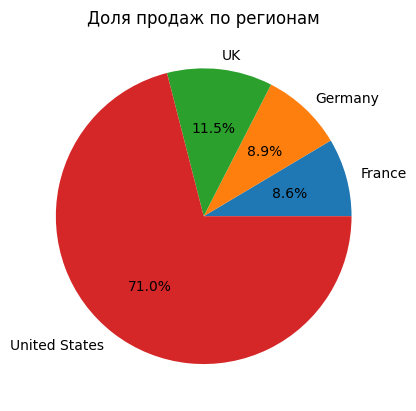

In [1660]:
pie = df.groupby("region")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по регионам")
plt.show()

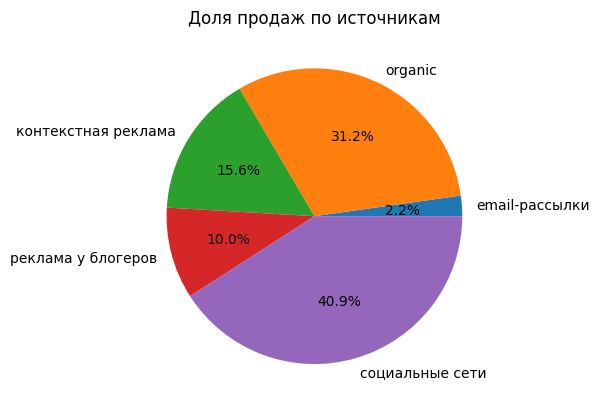

In [1661]:
pie = df.groupby("channel")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по источникам")
plt.show()

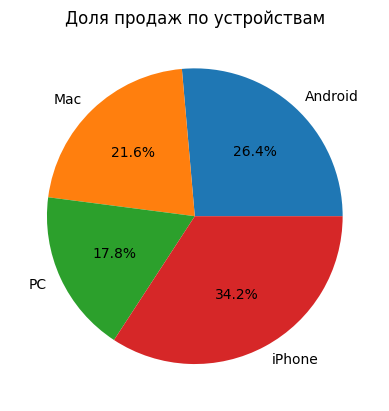

In [1662]:
pie = df.groupby("device")["payer"].sum()
pie.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.title("Доля продаж по устройствам")
plt.show()

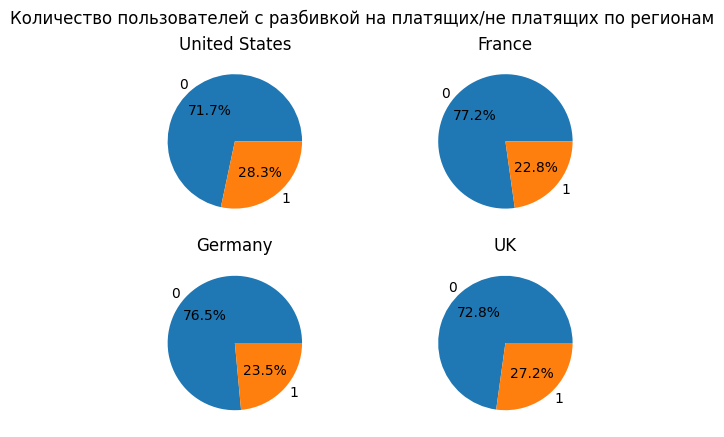

In [1663]:
fig, axs = plt.subplots(2, 2)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1)]
regions = df["region"].unique().tolist()

for i in range(len(regions)):
    region = regions[i]
    axs[ax_inds[i]].pie(df[df["region"] == region].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(region)

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по регионам")

plt.ylabel("")
plt.show()

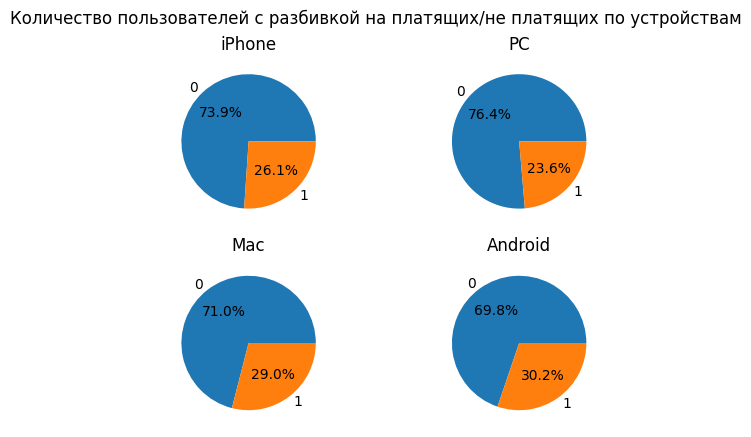

In [1664]:
fig, axs = plt.subplots(2, 2)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1)]
devices = df["device"].unique().tolist()

for i in range(len(devices)):
    device = devices[i]
    axs[ax_inds[i]].pie(df[df["device"] == device].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(device)

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по устройствам")

plt.ylabel("")
plt.show()

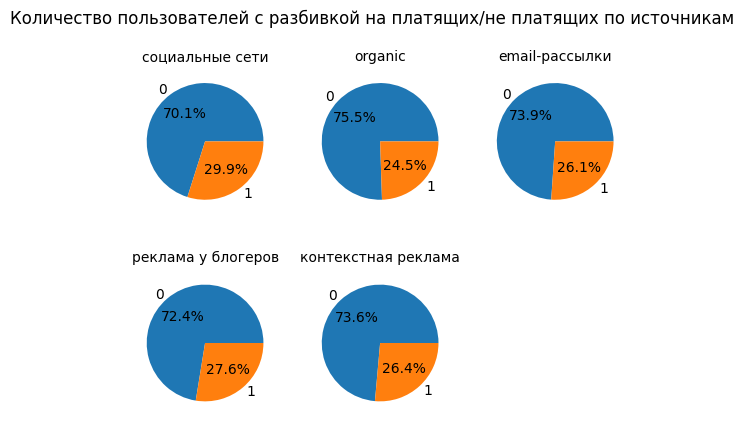

In [1665]:
fig, axs = plt.subplots(2, 3)

labels = [0, 1]

ax_inds = [(0, 0), (0, 1), (1, 0), (1, 1), (0, 2)]
channels = df["channel"].unique().tolist()

for i in range(len(channels)):
    channel = channels[i]
    axs[ax_inds[i]].pie(df[df["channel"] == channel].groupby("payer")["payer"].count(),
                        labels=labels, autopct='%.1f%%')
    axs[ax_inds[i]].set_title(channel, fontsize=10)

axs[(1, 2)].axis('off')

plt.suptitle("Количество пользователей с разбивкой на платящих/не платящих по источникам")

plt.ylabel("")
plt.show()

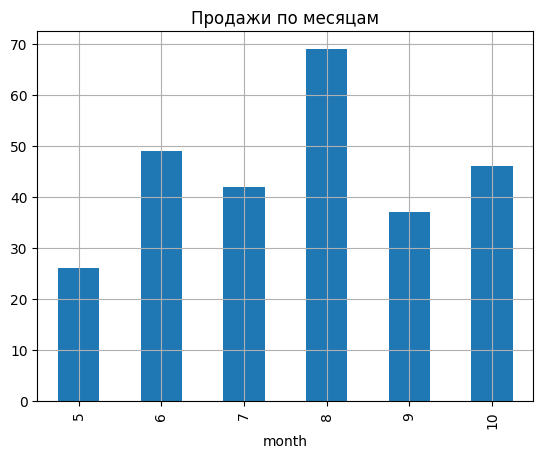

In [1666]:
hist = df[df["payer"] == 1].value_counts("month", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по месяцам")
plt.show()

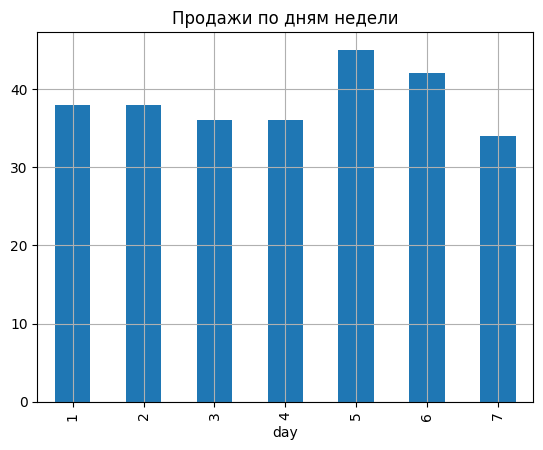

In [1667]:
hist = df[df["payer"] == 1].value_counts("day", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по дням недели")
plt.show()

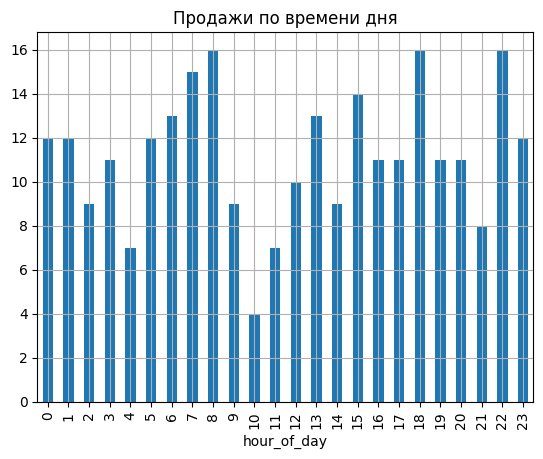

In [1668]:
hist = df[df["payer"] == 1].value_counts("hour_of_day", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по времени дня")
plt.show()

Ночью покупали больше всего? Это связано с тем, что основные покупатели из Америки, где в это время день, а у нас ночь.

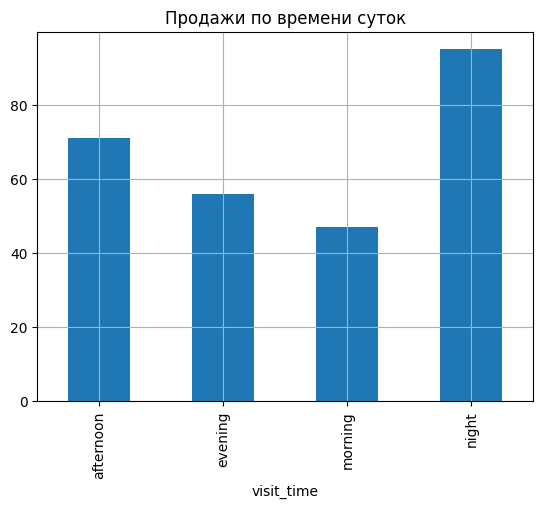

In [1669]:
hist = df[df["payer"] == 1].value_counts("visit_time", sort=False)
hist.plot.bar(grid=True)
plt.title("Продажи по времени суток")
plt.show()

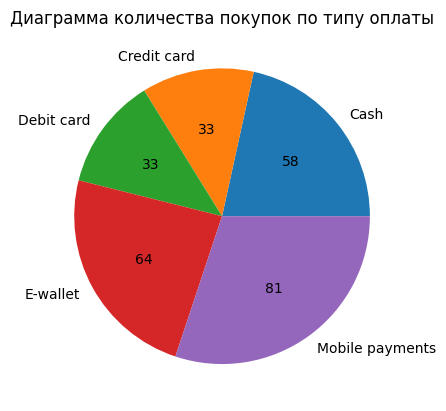

In [1670]:
pie = df[df["payer"] == 1].groupby("payment_type").sum("payer")["payer"]
pie.plot.pie(autopct=lambda x: '{:.0f}'.format(x * pie.sum() / 100))
plt.ylabel("")
plt.title("Диаграмма количества покупок по типу оплаты")
plt.show()

Первая и вторая гипотеза через ANOVA (не интересно)

1. Влияет ли тип устройства на количество покупок в день по каждому региону?

2. Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

In [1671]:
regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    devices = region_data['device'].unique()

    devices_res = []

    for device in devices:
        dev = region_data[region_data["device"] == device].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        devices_res.append(dev)

    stats, pvalue = f_oneway(*devices_res)
    print(region, stats, pvalue)

regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    channels = region_data['channel'].unique()

    channels_res = []

    for channel in channels:
        dev = region_data[region_data["channel"] == channel].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        channels_res.append(dev)

    stats, pvalue = f_oneway(*channels_res)
    print(region, stats, pvalue)

United States 1.063960071630043 0.36620709138862023
France nan nan
Germany nan nan
UK 1.1074074074074076 0.36396392117603416
United States 1.803404682291817 0.14966610966390423
France 0.742063492063492 0.5415729350540206
Germany 0.2980318650421743 0.8263461446417601
UK 0.35632183908045983 0.7849822422282045


C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


Первая и вторая гипотеза через t-test (интересно для девайсов по usa)

In [1672]:
regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    devices = region_data['device'].unique()
    for device in devices:
        dev = region_data[region_data["device"] != device].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        stats, pvalue = ttest_ind(reg, dev)
        if pvalue < 0.05:
            print("влияет", region, device, stats, pvalue)
        else:
            print("Не влияет", region, device, stats, pvalue)
    print()

regions = df['region'].unique()
for region in regions:
    region_data = df[(df['region'] == region) & (df["payer"] == 1)]
    reg = region_data.groupby("session_date")["payer"].count().reset_index(name="count")["count"]

    channels = region_data['channel'].unique()
    for channel in channels:
        dev = region_data[region_data["channel"] != channel].groupby("session_date")["payer"].count().reset_index(name="count")["count"]
        stats, pvalue = ttest_ind(reg, dev)
        if pvalue < 0.05:
            print("влияет", region, channel, stats, pvalue)
        else:
            print("Не влияет", region, channel, stats, pvalue)
    print()

влияет United States iPhone 2.368403300485016 0.018919183214114274
Не влияет United States Android 1.217630002351339 0.22487465197492676
Не влияет United States PC 0.7801261466922776 0.4362297757693494
влияет United States Mac 1.9781445347791315 0.04930629968059333

Не влияет France Android -0.4223486455268646 0.6755097520683004
Не влияет France PC 1.1787593835090049 0.24692368424985117
Не влияет France Mac 1.3407351901857554 0.1881804069483144
Не влияет France iPhone -0.1028832261219981 0.9185966885284058

Не влияет Germany Mac 0.3504922646595867 0.7279048193249777
Не влияет Germany PC 0.7647861629071293 0.449525006826485
Не влияет Germany Android 0.07917345879883642 0.937358816412666
Не влияет Germany iPhone 0.7647861629071293 0.449525006826485

Не влияет UK PC 0.1530504110821125 0.8790914825602867
Не влияет UK Android 0.21092886686893664 0.833939216117857
Не влияет UK Mac 0.5044794833720915 0.6162325923439126
Не влияет UK iPhone 0.265939043706987 0.7915283600680316

влияет United St

C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Roma\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Гипотеза 3: Проверить гипотезу о том, что средний чек отличается в зависимости от региона?

In [1673]:
df[df["payer"] == 1].groupby("region")["total_price"].mean()

region
France           5255.547826
Germany          5344.862500
UK               5540.954839
United States    5422.067539
Name: total_price, dtype: float64

Гипотеза 4: Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?

In [1674]:
df[df["payer"] == 1].groupby("channel")["total_price"].mean()

channel
email-рассылки         5332.366667
organic                5432.365476
контекстная реклама    5122.847619
реклама у блогеров     5380.496296
социальные сети        5525.390000
Name: total_price, dtype: float64

Гипотеза 5: Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?

In [1675]:
df[df["payer"] == 1].groupby("visit_time")["total_price"].mean()

visit_time
afternoon    5448.321127
evening      5479.400000
morning      5109.670213
night        5502.180000
Name: total_price, dtype: float64

Гипотеза 6: Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

In [1676]:
df[df["payer"] == 1][["session_duration_sec", "total_price"]].corr("spearman")  # корреляции очень слабая

,session_duration_sec,total_price
session_duration_sec,1.000000,-0.023183
total_price,-0.023183,1.000000


Гипотеза 7: Влияет ли регион на тип оплаты продукта?

In [1677]:
cont_table = pd.crosstab(df["region"], df["payment_type"])
chi2_contingency(cont_table).pvalue # данные между регионом и типом оплаты независимы (недостаточно данных)

0.9724674757265976

Гипотеза 8: Влияет ли день недели на кол-во покупок?

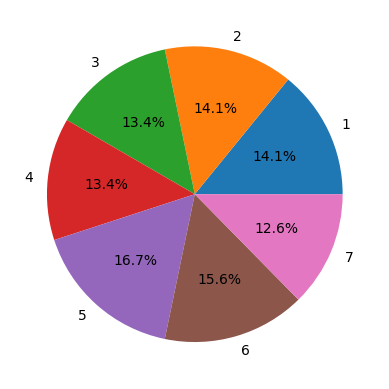

In [1678]:
bh = df[df["payer"] == 1]
bh = bh.groupby("day")["payer"].count()
bh.plot.pie(autopct='%.1f%%')
plt.ylabel("")
plt.show() # Из диаграммы видно, что особых различий между кол-вом покупок нет. Вывод: день недели не зависит от покупок

Регрессионная модель факторов *region*, *channel* и отклика *payer*

In [1679]:
a = ["region", "channel"]
X = df[a]
y = df[["payer"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(sparse_output=False), a)],
    remainder='passthrough'
)

X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

model = LinearRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратичная ошибка модели: {mse}")
print(r2)

Среднеквадратичная ошибка модели: 0.21065655425565327
-0.04173454109367203
